In [ ]:
# To track our robot we need to maintain states for x, y, and heading. 
#   We will store N particles in a (N, 3) shaped array. 
#      The three columns contain x, y, and heading, in that order.
#       In this problem the robot can move on a plane of some arbitrary dimension, 
#         with the lower right corner at (0,0).

In [1]:
# Code creating particle

from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
from numpy.linalg import norm
import scipy.stats
from numpy.random import normal, randn, random, uniform, multivariate_normal, seed


def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

In [2]:
 create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

array([[0.94607372, 0.14495423, 1.01312061],
       [0.5095611 , 0.94738482, 4.52842957],
       [0.36440626, 0.41569336, 3.34501899],
       [0.96083615, 0.14270906, 0.36071144]])

In [3]:
def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

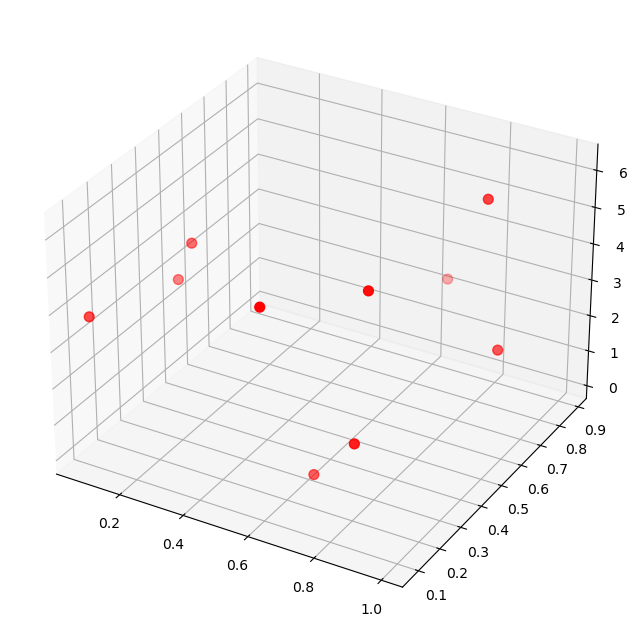

In [4]:
N = 10
particles_generated = create_uniform_particles((0,1), (0,1), (0, np.pi*2), N)
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

x = particles_generated[:, 0]
y = particles_generated[:, 1]
theta = particles_generated[:, 2]
ax.scatter(x, y,theta, c = 'r', s = 50)

C:\Users\seme\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

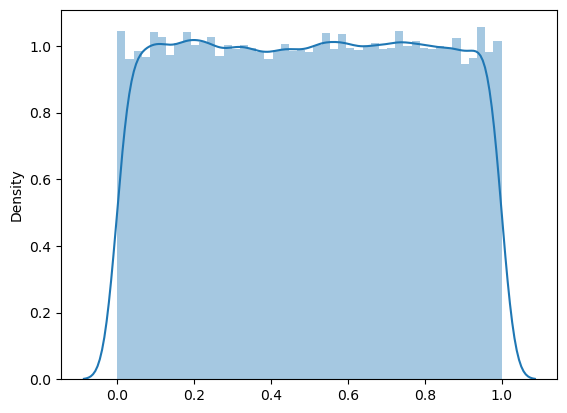

In [5]:
sns.distplot(uniform(size=100000), hist=True)
# uniform : any value within the given interval is equally likely to be drawn by uniform.
# (a, b, size) a - lower bound - default 0 , b - upper bound - default 1 , size - The shape of the returned array.

C:\Users\seme\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

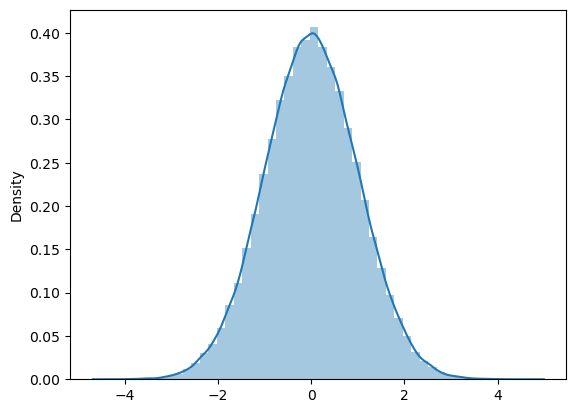

In [6]:
# Normal (gaussian)  distributionIt fits the probability distribution of many events, eg. IQ Scores, Heartbeat etc.

# It has three parameters: loc - (Mean) where the peak of the bell exists , scale - (Standard Deviation) how flat the graph distribution should be.
# size - The shape of the returned array. ,#  deafult: mean : 0 , std = 1
sns.distplot(normal(size=100000), hist=True)

In [7]:
#Code predict function
def predict(particles, u, std, dt=1.):
        """ move according to control input u (heading change, velocity)
        with noise Q (std heading change, std velocity)`"""
        N = len(particles)
        # update heading
        particles[:, 2] += u[0] + (randn(N) * std[0])
        particles[:, 2] %= 2 * np.pi
        # move in the (noisy) commanded direction
        
        dist = (u[1] * dt) + (randn(N) * std[1])
        particles[:, 0] += np.cos(particles[:, 2]) * dist
        particles[:, 1] += np.sin(particles[:, 2]) * dist

In [8]:
# Each particle has a position and a weight which estimates how well it matches the measurement. 
#Normalizing the weights so they sum to one turns them into a probability distribution
#The particles those that are closest to the robot will generally have a higher weight 
# The weights are the likelihood in Bayes theorem.

#Code update function
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])
        weights += 1.e-300 # avoid round-off to zero
        weights /= sum(weights) # normalize
        
# z: distance from robot to each landmark
# R : sensor_std_err
# Sequential Importance Sampling, SIS

In [9]:
likelihood of observing z[i] given predicted distance
places the observation (distance) as the distribution's center

# current: predicted value (distance) is used to model the likelihood of an observation (z[i]).
# other:  likelihood of the predicted value (distance) given the observation (z[i]).

SyntaxError: invalid syntax (456250135.py, line 1)

In [10]:
#Computing the State Estimate :want to know the estimated state after each update, 
#but the filter consists of nothing but a collection of particles. 
# Assuming that we are tracking one object, we can compute the mean of the estimate as the sum of the weighted values of the particles.


#Code estimate function
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var


In [ ]:
#Mean: The weighted average position of the particles.
#Variance: A measure of how spread out the particles are around the mean.
# after calculating the mean, finds the deviation of each particle position from the mean

In [ ]:
#If we create a uniform distribution of points in a 1x1 square with equal weights
#  we get a mean position very near the center of the square at (0.5, 0.5) and a small variance.

particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

In [ ]:
The SIS algorithm suffers from the degeneracy problem. It starts with uniformly distributed particles with equal weights. There may only be a handful of particles near the robot. As the algorithm runs any particle that does not match the measurements will acquire an extremely low weight. We could have 5,000 particles with only 3 contributing meaningfully to the state estimate! We say the filter has degenerated. This problem is usually solved by some form of resampling of the particles.
Particles with very small weights do not meaningfully describe the probability distribution of the robot. The resampling algorithm discards particles with very low probability and replaces them with new particles with higher probability. It does that by duplicating particles with relatively high probability. 


In [11]:
#Code resampling functions 

def multinomal_resample(weights):
    cumulative_sum = np.cumsum(weights) # Cumulative Sum of Weights
    random_numbers = random(len(weights)) # Generate Random Numbers
    #return np.searchsorted(cumulative_sum, random(len(weights))) 
    return np.searchsorted(cumulative_sum, random_numbers) # return indices
# searchsorted: finds the indices where elements should be inserted into a sorted array to maintain the order.

In [ ]:
a = [.1, .2, .3, .4, .2, .3, .1]
print(np.cumsum(a))
randomnumbers = random(len(a))
print(randomnumbers)
np.searchsorted(np.cumsum(a), randomnumbers)# where to instert randomnumbers into cumsum

In [12]:
def plot_multinomial_resample(a):
    listLength = len(a)
    cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan']*(int(listLength/4) + 1))
    cumsum = np.cumsum(np.asarray(a) / np.sum(a))
    cumsum = np.insert(cumsum, 0, 0)

    fig = plt.figure()
    ax = plt.gcf().add_axes([0.05, 0.475, 1.5, 0.25])
    norm = mpl.colors.BoundaryNorm(cumsum, cmap.N)
    bar = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                     norm=norm,
                                     spacing='proportional',
                                     orientation='horizontal')

    # make N subdivisions, and chose a random position within each one
    b = random(listLength)
    plt.scatter(b, [.5]*len(b), s=60, facecolor='k')
    plt.title('multinomial resampling')

In [13]:
def systematic_resample(weights):
    """ 
    This algorithm separates the sample space into N divisions. A single random
    offset is used to to choose where to sample from for all divisions. This
    guarantees that every sample is exactly 1/N apart.

    Parameters
    ----------
    weights :  list of weights as floats


    Returns
    -------
    indexes :  array of indexes into the weights defining the resample. i.e. the
       
    """
    N = len(weights)

    # make N subdivisions, and choose positions with a consistent random offset
    positions = (random() + np.arange(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [ ]:
i, j = 0, 0
indexes = np.zeros(7, 'i')

while i < 7:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1

In [ ]:
a = [.1, .2, .3, .4, .2, .3, .1]
N = len(a)
positions = (random() + np.arange(N)) / N # i
cumulative_sum = np.cumsum(a) # j


In [ ]:
positions

In [ ]:
cumulative_sum

In [ ]:
indexes

In [14]:
def plot_systematic_resample(a):
    listLength = len(a)
    cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan']*(int(listLength/4) + 1))
    cumsum = np.cumsum(np.asarray(a) / np.sum(a))
    cumsum = np.insert(cumsum, 0, 0)

    fig = plt.figure()
    ax = plt.gcf().add_axes([0.05, 0.475, 1.5, 0.25])
    norm = mpl.colors.BoundaryNorm(cumsum, cmap.N)
    bar = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                     norm=norm,
                                     spacing='proportional',
                                     orientation='horizontal')
    # make N subdivisions, and chose a random position within each one
    b = (random() + np.array(range(N))) / N
    plt.scatter(b, [.5]*len(b), s=60, facecolor='k')
    plt.title('systematic resampling')

In [15]:
def stratified_resample(weights):
    """     This algorithms aims to make selections relatively uniformly across the
    particles. It divides the cumulative sum of the weights into N equal
    divisions, and then selects one particle randomly from each division. This
    guarantees that each sample is between 0 and 2/N apart.

    Parameters
    ----------
    weights :  list of weights as floats

    Returns
    -------

    indexes :  array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """

    N = len(weights)
    # make N subdivisions, and chose a random position within each one
    positions = (random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [16]:
def plot_stratified_resample(a):
    listLength = len(a)
    cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan']*(int(listLength/4) + 1))
    cumsum = np.cumsum(np.asarray(a) / np.sum(a))
    cumsum = np.insert(cumsum, 0, 0)

    fig = plt.figure()
    ax = plt.gcf().add_axes([0.05, 0.475, 1.5, 0.25])
    norm = mpl.colors.BoundaryNorm(cumsum, cmap.N)
    bar = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                     norm=norm,
                                     spacing='proportional',
                                     orientation='horizontal')

    # make N subdivisions, and chose a random position within each one
    b = (random(N) + range(N)) / N
    plt.scatter(b, [.5]*len(b), s=60, facecolor='k')
    plt.title('stratified resampling')

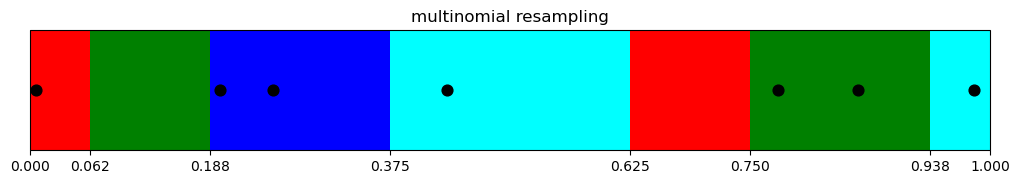

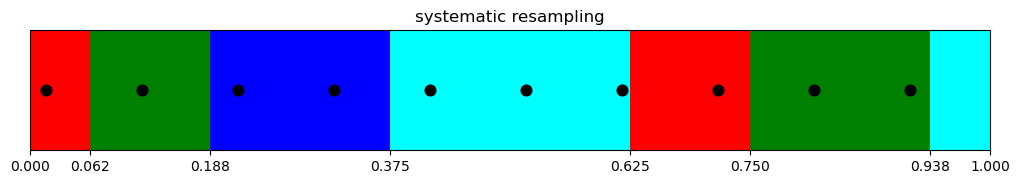

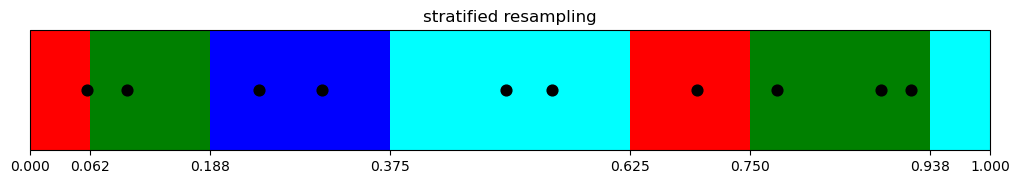

In [17]:
a = [.1, .2, .3, .4, .2, .3, .1]
np.random.seed(4)
multinomal_resample(a)
plot_multinomial_resample(a)
plot_systematic_resample(a)
plot_stratified_resample(a)

In [18]:
#The performance of the multinomial resampling is quite bad. There is a very large weight that was not sampled at all. The largest weight only got one resample, yet the smallest weight was sample was sampled twice.
# Systematic sampling does an excellent job of ensuring we sample from all parts of the particle space while ensuring larger weights are proportionality resampled more often. 
#Stratified resampling is not quite as uniform as systematic resampling, but it is a bit better at ensuring the higher weights get resampled more.

In [19]:
multinomal_resample(a)

array([0, 3, 1, 3, 2, 2, 3], dtype=int64)

In [ ]:
#We don't resample at every epoch. if you received no new measurements you have not received any information from which the resample can benefit.
#We can determine when to resample by using something called the effective N, which approximately measures the number of particles which meaningfully contribute to the probability distribution. 

In [20]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [21]:
#Code resample from index  functions 

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes] # High-weight particles are more likely to be duplicated, as indexes  comes from a sampling process 
    weights.resize(len(particles)) # After resampling, all particles are given equal weights because their new distribution already reflects their importance based on the previous weighting and resampling process.
    weights.fill (1.0 / len(weights)) # The weights are set to 1/𝑁 , where N is the number of particles
    
    

In [31]:
def run_pf1(N, sensor_std_err=.1):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    weights = np.ones(N) / N

    # create particles and weights
    #particles = create_gaussian_particles(mean=(1,1, np.pi/4), std=(5, 5, np.pi/4), N=N)
    particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    plt.scatter(particles[:, 0], particles[:, 1], alpha=0.04, color='g')
         
    robot_pos = np.array([0., 0.])
    iters=18
    for x in range(iters):
        robot_pos += (1, 1) 

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err)) # randn : Gaussian) distribution of mean 0 and variance 1

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.00002, .0000005))
        #predict(particles, u=(0.00, 1.414), std=(.2, .05))

        #  The standard deviation for the error in the turn is 0.2, for the distance is 0.05
        # When this call returns the particles will all have been moved forward, 
        #      but the weights are no longer correct as they have not been updated.
        #
        #
        
        # incorporate measurements into filter
        update(particles, weights, z=zs, R=sensor_std_err,landmarks=landmarks)
        
        #  This does not alter the particle positions, it only alters the weights. 
        #
        # The further the particle from the measured distance
        #     the less likely it is to be a good representation.
        
        # resample if too few effective particles
        xs = []
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            #indexes = multinomal_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        
        # plot 
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
        p3 = plt.scatter(particles[:, 0], particles[:, 1],color='b', marker=',', s=1)

    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)

final position error, variance:
	 [-8.19775562  5.60757139] [1.21929863e-06 2.02552545e-07]


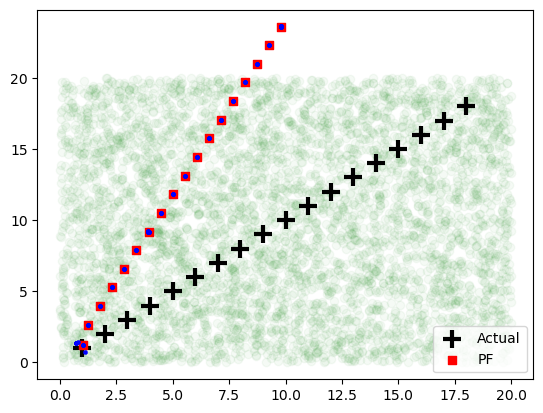

In [32]:
from numpy.random import seed
seed(2) 
run_pf1(N=5000)

final position error, variance:
	 [-0.10621456  0.1061402 ] [0.00859646 0.00757081]


(0.0, 6.0)

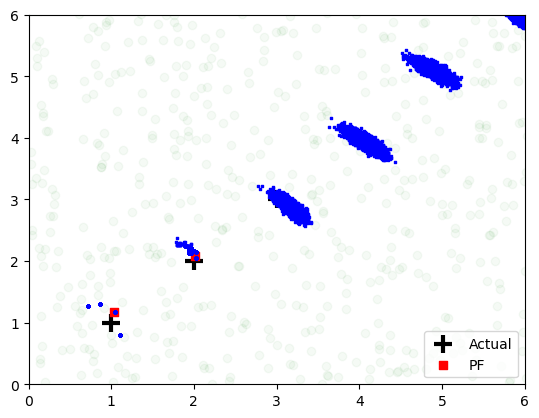

In [24]:
seed(2)
run_pf1(N=5000)
plt.xlim(0,6)
plt.ylim(0,6)

In [ ]:
#ew particles are visible at the first two robot positions due to resampling of duplicates.
#A narrow sensor Gaussian causes sample impoverishment, risking filter divergence. 
#At x=2, particles have dispersed. 
# All particles are projected forward with control input u, but noise is added based on control error.

In [ ]:
The first few iterations of the filter resulted in many duplicate particles. This happens because the model for the sensors is Gaussian, and we gave it a small standard deviation of 
The Kalman filter performs better when the noise is smaller, yet the particle filter can perform worse.

In [ ]:
ighly accurate sensors can paradoxically harm filter performance by limiting the number of particles accurately representing the true probability distribution. To address this:

Artificially increasing sensor noise can broaden the acceptance range for particle matches, but this may include inaccurate points.
Increasing the number of particles (N) directly provides more particles near the robot, improving accuracy.

final position error, variance:
	 [-0.06514561  0.00945016] [0.0090194  0.00900461]


(0.0, 6.0)

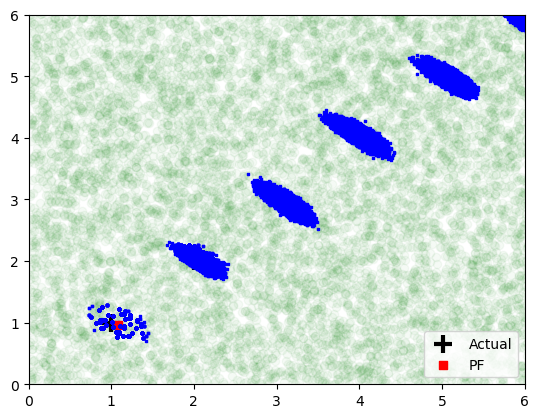

In [25]:
seed(2)
run_pf1(N=100000)
plt.xlim(0,6)
plt.ylim(0,6)

In [ ]:
Clearly the filter is performing better, but at the cost of large memory usage and long run times.

Another approach is to be smarter about generating the initial particle cloud.
#Suppose we guess that the robot is near (0, 0). This is not exact, as the simulation actually places the robot at (1, 1), but it is close.
#If we create a normally distributed cloud near (0, 0) there is a much greater chance of the particles matching the robot's position.

final position error, variance:
	 [-0.0705476  -0.01034114] [0.00642743 0.00794858]


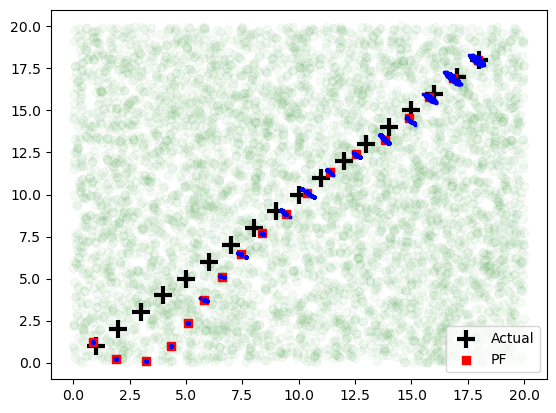

In [26]:
seed(6) 
run_pf1(N=5000)


final position error, variance:
	 [-0.0705476  -0.01034114] [0.00642743 0.00794858]


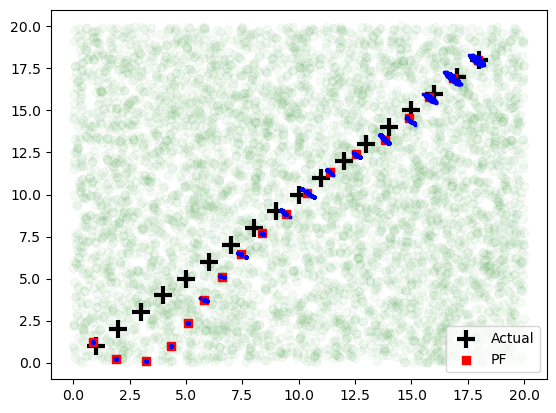

In [27]:
seed(6) 
run_pf1(N=5000)

In [ ]:
This works great. You should always try to create particles near the initial position if you have any way to roughly estimate it. Do not be too careful - if you generate all the points very near a single position the particles may not be dispersed enough to capture the nonlinearities in the system.

final position error, variance:
	 [ 0.03533921 -0.07658383] [0.0074115  0.00932576]


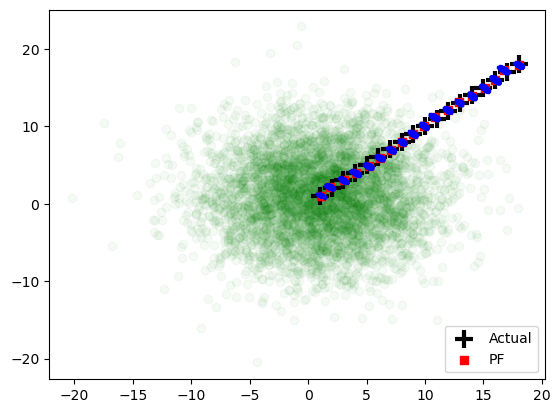

In [30]:
seed(6) 
run_pf1(N=5000)
